### MasaCtrl: Tuning-free Mutual Self-Attention Control for Consistent Image Synthesis and Editing

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
import numpy as np

from diffusers import DDIMScheduler, StableDiffusionPipeline
from diffusers.utils.torch_utils import randn_tensor
from masactrl.masactrl_utils import regiter_attention_editor_diffusers
from torchvision.transforms.functional import gaussian_blur
import cv2
from torchvision.utils import save_image
from torchvision.io import read_image
from pytorch_lightning import seed_everything
from matplotlib import pyplot as plt
torch.cuda.set_device(0)  # set the GPU device

/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-14 08:31:06.992154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 08:31:08.168315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
dtype = torch.float16
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_path = "../SD2-1-base"
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    scheduler=scheduler,
    custom_pipeline="./pipelines/pipeline_inversion.py",
    torch_dtype=dtype
)
pipe = pipe.to(device)
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]
/root/.cache/huggingface/modules/diffusers_modules/local/pipeline_inversion.py:203: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would b

In [4]:
""" #freeU
from utils import register_free_upblock2d, register_free_crossattn_upblock2d
register_free_upblock2d(pipe, b1=1.4, b2=1.6, s1=0.9, s2=0.2)
register_free_crossattn_upblock2d(pipe, b1=1.4, b2=1.6, s1=0.9, s2=0.2) """

' #freeU\nfrom free_lunch_utils import register_free_upblock2d, register_free_crossattn_upblock2d\nregister_free_upblock2d(pipe, b1=1.4, b2=1.6, s1=0.9, s2=0.2)\nregister_free_crossattn_upblock2d(pipe, b1=1.4, b2=1.6, s1=0.9, s2=0.2) '

In [5]:
def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    if image.shape[1] != 3:
        image = image.expand(-1, 3, -1, -1)
    image = F.interpolate(image, (512, 512), mode="bicubic")
    #image = F.interpolate(image, (768, 768), mode="bicubic")
    image = image.to(dtype).to(device)
    return image

def load_mask(mask_path, device):
    mask = read_image(mask_path,mode=ImageReadMode.GRAY)
    mask = mask.unsqueeze_(0).float() / 255.  # 0 or 1
    mask = F.interpolate(mask, (512, 512), mode="bicubic")
    #mask = F.interpolate(mask, (768, 768), mode="bicubic")
    mask = gaussian_blur(mask, kernel_size=(7,7))
    mask[mask < 0.1] = 0
    mask[mask >= 0.1] = 1
    mask = mask.to(dtype).to(device)
    return mask

seed = 123
seed_everything(seed)
generator=torch.Generator("cuda").manual_seed(seed)
sample = "an" 
out_dir = f"./workdir_inp/{sample}/"
os.makedirs(out_dir, exist_ok=True)
sample_count = len(os.listdir(out_dir))
out_dir = os.path.join(out_dir, f"sample_{sample_count}")
os.makedirs(out_dir, exist_ok=True)
# source image
SOURCE_IMAGE_PATH = f"./examples/img/{sample}.png"
MASK_PATH = f"./examples/mask/{sample}_mask.png"
prompt = ""
source_image = load_image(SOURCE_IMAGE_PATH, device)
mask_an = load_mask(MASK_PATH, device)


In [6]:
source_prompt = ""
target_prompt = ""
with torch.no_grad():
    # invert the source image
    start_code, latents_list = pipe.invert(
                                source_image,
                                source_prompt,
                                generator=generator,
                                guidance_scale=1,
                                num_inference_steps=40,
                                return_intermediates=True)

In [7]:
from AAS.AAS import AAS ,AAS_768
from AAS.AAS_utils import regiter_attention_editor_diffusers

START_STEP = 0
END_STEP = 40
LAYER = 7#0~5down,6mid,7~15up
END_LAYER = 16

attentionstore = None
layer_idx=list(range(LAYER, END_LAYER))

editor = AAS(attentionstore, START_STEP, END_STEP, LAYER, END_LAYER,layer_idx= layer_idx, mask=mask_an, ss_steps=9,ss_scale=0.3)
regiter_attention_editor_diffusers(pipe, editor)

image = pipe(
    target_prompt,
    width=512,
    height=512,
    num_inference_steps=40,
    guidance_scale=1.0,
    latents=start_code,
    generator=generator,
    x0_latents=latents_list[0],
    record_list = list(reversed(latents_list)),
    mask = mask_an,
    removal_guidance_scale = 9, #5
    return_intermediates = False,
)

AAS at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
AAS at U-Net layers:  [7, 8, 9, 10, 11, 12, 13, 14, 15]
start AAS


In [8]:
def make_redder(img, mask, increase_factor=0.25):
    # 创建一个拷贝以避免修改原始图像
    img_redder = img.clone()
    mask_expanded = mask.expand_as(img)
    # 增加红色分量（第一个通道）在 mask 为 1 的区域
    img_redder[0][mask_expanded[0] == 1] = torch.clamp(img_redder[0][mask_expanded[0] == 1] + increase_factor, 0, 1)
    
    return img_redder
img = (source_image* 0.5 + 0.5).squeeze(0)
mask = mask_an.squeeze(0)
img_redder = make_redder(img, mask)
#save_image(img_redder, os.path.join(out_dir, "redder.png"))

In [9]:
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image, ImageFilter
pil_mask = to_pil_image(mask.squeeze(0))
pil_mask_blurred = pil_mask.filter(ImageFilter.GaussianBlur(radius=15))
mask_blurred = to_tensor(pil_mask_blurred).unsqueeze_(0).to(mask.device)

Syntheiszed images are saved in ./workdir_inp/an/sample_0


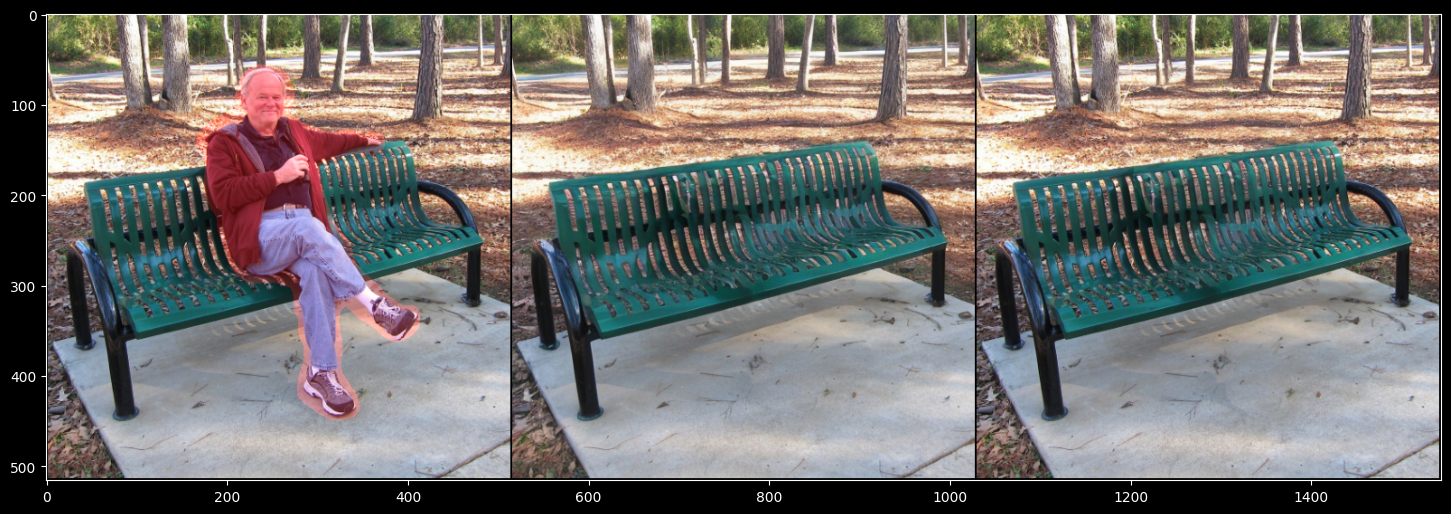

In [10]:
out_tile = mask * image[-1:] + (1 - mask) * (source_image* 0.5 + 0.5)
out_tile_1 = mask_blurred * image[-1:] + (1 - mask_blurred) * out_tile
#out_image = torch.concat([source_image* 0.5 + 0.5,
out_image = torch.concat([img_redder.unsqueeze(0),
                         image[-1:],
                         out_tile_1],
                         #image[:1]],
                         dim=0)
save_image(out_image, os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[0], os.path.join(out_dir, f"source_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[1], os.path.join(out_dir, f"anonymous_step{END_STEP}_layer{LAYER}.png"))
save_image(out_image[2], os.path.join(out_dir, f"anonymous_tile_step{END_STEP}_layer{LAYER}.png"))
#save_image(out_image[2], os.path.join(out_dir, f"compare_step{END_STEP}_layer{LAYER}.png"))
print("Syntheiszed images are saved in", out_dir)
img_ori = cv2.imread(os.path.join(out_dir, f"all_step{END_STEP}_layer{LAYER}.png"))
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(18, 24))
plt.imshow(img_ori)